# Building Unimodal Text Model

In [15]:
cd ..

e:\notebooks


In [16]:
#ensuring that any edits to libraries you make are reloaded here automatically
#to ensuere charts or images displayed are shown in this notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

In [17]:
#importing required modules
from exp.Required_Modules_And_Packages import *
from exp.Data_Reading_And_Preprocessing import *
from exp.Required_Integration_Functionalities_For_Transformer_To_Fastai import *
from exp.Required_Functionalities_To_Handal_Multimodal_Dataset import *
from exp.Multimodal_Model_With_Intermediate_Or_EmbraceNet_Fusion import *

In [18]:
path = Path('/notebooks/MultimodalTweetsClassification')
# path.ls()

In [19]:
path_img = path/'data_image'

In [20]:
# Uncomment the code if dataset and labels are in .tar.gz and .zip format respectively

# data = "CrisisMMD_v2.tar.gz"
# agreed_label = "crisismmd_datasplit_agreed_label.zip"
# untar_data_and_unzip_label(data,agreed_label)

In [21]:
#reading csv files and doing initial necessary processing
data_info_text,test_data_info_text = get_dataframe(*get_tsv_data_files('Informativeness_task_tsv_files'),path)

reading data and preprocessing it.....
done!!


In [22]:
print(f"shape of data: {data_info_text.shape}\n")
print(f"train set: {data_info_text['is_valid'].value_counts()[0]}")
print(f"valid set: {data_info_text['is_valid'].value_counts()[1]}")      
print("="*50)
print(f"shape of test data: {test_data_info_text.shape}\n")

shape of data: (15844, 10)

train set: 13607
valid set: 2237
shape of test data: (2237, 9)



In [23]:
data_info_text.head()

,event_name,tweet_id,image_id,tweet_text,image,label,label_text,label_image,label_text_image,is_valid
0,california_wildfires,917791291823591425,917791291823591425_1,pls share were capturing wildfire response rec...,data_image/california_wildfires/10_10_2017/917...,not_informative,informative,not_informative,Negative,False
1,california_wildfires,917793137925459968,917793137925459968_0,california wildfires destroy more than structu...,data_image/california_wildfires/10_10_2017/917...,informative,informative,informative,Positive,False
2,california_wildfires,917793137925459968,917793137925459968_1,california wildfires destroy more than structu...,data_image/california_wildfires/10_10_2017/917...,informative,informative,informative,Positive,False
3,california_wildfires,917793137925459968,917793137925459968_2,california wildfires destroy more than structu...,data_image/california_wildfires/10_10_2017/917...,informative,informative,informative,Positive,False
4,california_wildfires,917815040962695168,917815040962695168_0,photos of california destructive wildfires via,data_image/california_wildfires/10_10_2017/917...,informative,informative,informative,Positive,False


In [24]:
# Self

In [25]:
from transformers import BertTokenizer, BertForSequenceClassification
from exp.Required_Integration_Functionalities_For_Transformer_To_Fastai import (
    TransformersBaseTokenizer, TransformersVocab, CustomTransformerModel
)
from exp.Required_Modules_And_Packages import *
from exp.Data_Reading_And_Preprocessing import *

In [26]:
num_labels = len(data_info_text['label_text'].unique())
model_path = r"e:\notebooks\MultimodalTweetsClassification\bert_local"
hf_tokenizer = BertTokenizer.from_pretrained(model_path)
hf_model = BertForSequenceClassification.from_pretrained(model_path, num_labels=num_labels)

In [27]:
fastai_tokenizer = TransformersBaseTokenizer(hf_tokenizer)
fastai_vocab = TransformersVocab(hf_tokenizer)

In [28]:
from fastai.text import Tokenizer, TokenizeProcessor, NumericalizeProcessor

fastai_tokenizer = Tokenizer(
    tok_func=TransformersBaseTokenizer(hf_tokenizer, model_type='bert'),
    pre_rules=[], post_rules=[], n_cpus=1
)
fastai_vocab = TransformersVocab(hf_tokenizer)

processor = [TokenizeProcessor(tokenizer=fastai_tokenizer), NumericalizeProcessor(vocab=fastai_vocab)]



def get_text_data(dataframe, path, pad_first=True, pad_idx=1, batch_size=64, processor=None, vocab=None, num_workers=0):
    text_data = (TextList.from_df(dataframe, path, cols='tweet_text', processor=processor, vocab=vocab)
                 .split_from_df(col='is_valid')
                 .label_from_df(cols='label_text')
                 .databunch(bs=batch_size, pad_first=pad_first, pad_idx=pad_idx, num_workers=num_workers))
    return text_data

# function to create databunch object of test text data using test split

def get_test_text_data(dataframe, path, pad_first=True, pad_idx=1, batch_size=64, processor=None, vocab=None, num_workers=0):
    test_text_data = (TextList.from_df(dataframe, path, cols='tweet_text', processor=processor, vocab=vocab)
                      .split_none()
                      .label_from_df(cols='label_text')
                      .databunch(bs=batch_size, pad_first=pad_first, pad_idx=pad_idx, num_workers=num_workers))
    return test_text_data


data_clas = get_text_data(
    data_info_text,
    path,
    processor=processor,
    vocab=fastai_vocab
)
test_data_clas = get_test_text_data(
    test_data_info_text,
    path,
    processor=processor,
    vocab=fastai_vocab
)
data_clas.add_test(test_data_clas.train_ds)
data_clas.test_ds.y = test_data_clas.train_ds.y

In [29]:
pad_idx = hf_tokenizer.pad_token_id
model = CustomTransformerModel(pad_idx, hf_model)

In [30]:
from torch.nn import CrossEntropyLoss

learn_clas = Learner(
    data_clas,
    model,
    loss_func=CrossEntropyLoss(),
    metrics=[accuracy, Precision1(average='macro'), Precision1(average='weighted')],
    callback_fns=[ShowGraph]
)

epoch,train_loss,valid_loss,accuracy,precision1,precision1,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-05
Min loss divided by 10: 1.20E-04


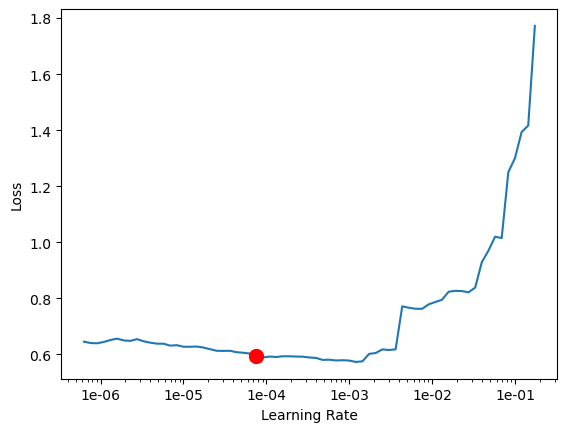

In [32]:
learn_clas.lr_find()
learn_clas.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,precision1,precision1,time
0,0.403550,0.390568,0.821636,0.782646,0.816374,27:44
1,0.338451,0.421392,0.822977,0.798295,0.816380,25:48
2,0.176076,0.552890,0.819401,0.779394,0.814184,26:34
3,0.072459,0.647166,0.821636,0.785484,0.815194,26:50


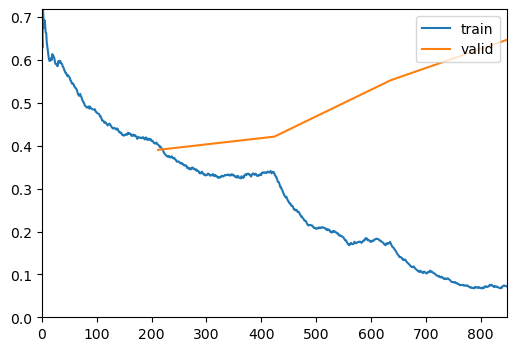

In [33]:
learn_clas.fit_one_cycle(4, 1e-4)

              precision    recall  f1-score   support

        INFO       0.85      0.91      0.88      1612
  Non - Info       0.72      0.60      0.65       625

    accuracy                           0.82      2237
   macro avg       0.79      0.75      0.77      2237
weighted avg       0.82      0.82      0.82      2237



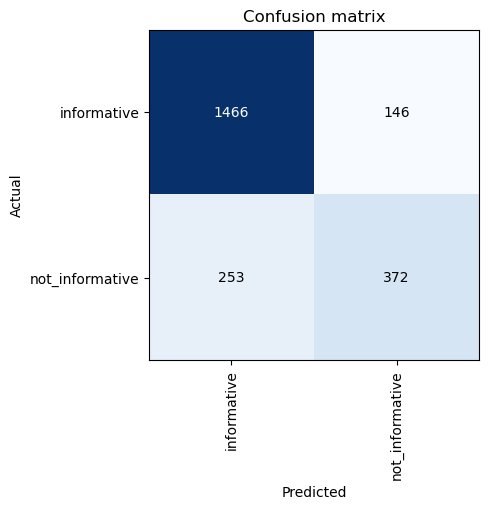

In [35]:
interp = ClassificationInterpretation.from_learner(learn_clas)
interp.plot_confusion_matrix(figsize=(5,5), dpi=100)

preds, y, losses = learn_clas.get_preds(ds_type=DatasetType.Valid, with_loss=True)
y_preds = preds.argmax(1)

target_names = [
    'INFO',
    'Non - Info',
]
print(classification_report(y, y_preds, target_names=target_names))